#**Recommandation qualitative : Creuse Movie Project**

Audrey - Anthony - Maxime - Malick

---



---


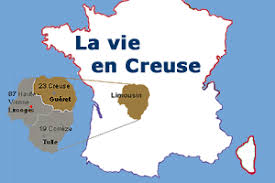

Nos sources :  

Github  
https://gist.github.com/rxaviers/7360908  


Wikipedia  
https://fr.wikipedia.org/wiki/TF-IDF


Panda.org  
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html


Kaggle  
https://www.kaggle.com/rounakbanik/the-story-of-film/


datasets IMDB  
https://www.lafabbricadellarealta.com/open-data-entertainment/

https://datasets.imdbws.com/

https://www.imdb.com/interfaces/


In [ ]:
# les modules utiles à notre analyse 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

# analyser des systèmes de recommandation traitant des données de notation .
!pip install scikit-surprise

import warnings; warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importons notre base de donées allégées
df_top =pd.read_csv('/content/drive/MyDrive/df_sample_top.csv')

In [ ]:
# un aperçu de la base
df_top.head(2)

,Unnamed: 0,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName
0,527769,tt0111161,movie,The Shawshank Redemption,1994,142,Drama,9.3,2377444,"Stephen King,Tim Robbins,Clancy Brown,Mark Rol..."
1,1156496,tt0468569,movie,The Dark Knight,2008,152,"Action,Crime,Drama",9.0,2341216,"Gary Oldman,Christian Bale,Michael Caine,Eric ..."


In [ ]:
# un arrondi sur nos chiffres
df_top = df_top.round(2)
df_top.head(2)

,Unnamed: 0,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName
0,527769,tt0111161,movie,The Shawshank Redemption,1994,142,Drama,9.3,2377444,"Stephen King,Tim Robbins,Clancy Brown,Mark Rol..."
1,1156496,tt0468569,movie,The Dark Knight,2008,152,"Action,Crime,Drama",9.0,2341216,"Gary Oldman,Christian Bale,Michael Caine,Eric ..."


#Cette fonction sera la base de notre analyse axée sur les notations

**IMDB'S Weighted Rating (WR)** =  $$  (\frac{v}{v+m}.R ) + (  \frac{v}{v+m}.C )    $$

 

v = numVotes for the movie  

m = minimum Numvotes  

R = the average rating of the movie  

C = mean of the averageRating





---



In [ ]:
 # mean of averageRating and numVotes
averageRating = df_top[df_top['averageRating'].notnull()]['averageRating'].astype('int')
numVotes= df_top[df_top['numVotes'].notnull()]['numVotes'].astype('int')

C =round ( averageRating.mean(),2)
B =round(numVotes.mean(),)

print ("averageRating.mean:",C)
print ("numVotes.mean:", B)

averageRating.mean: 5.59
numVotes.mean: 4553


In [ ]:
# let's work with the 95th percentile
m = round( numVotes.quantile(0.95))
m

9061

In [ ]:
# view of te columns
df_top.columns

Index(['Unnamed: 0', 'tconst', 'titleType', 'originalTitle', 'startYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'primaryName'],
      dtype='object')

In [ ]:
# df for the creuse movie project predictions
df = df_top[(df_top['numVotes'] >= m) & (df_top['numVotes'].notnull()) & (df_top['averageRating'].notnull())][[ 'tconst', 'titleType', 'originalTitle', 'startYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'primaryName']]
df.shape


(9552, 9)

#Nous avons choisi des films ayant au minimum9061 votes.  
La note moyenne d'un film est de 5.59.

Nous allons travailler sur un base de 9552 films



In [ ]:
# fonction pour déterminer nos variables de calcul
def weighted_rating(x):
    v = x['numVotes']
    R = x['averageRating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# les notes pondérées
df['wr'] = df.apply(weighted_rating, axis=1)

In [ ]:
# dimensions de la base de données
df.shape

(9552, 10)

In [ ]:
# trions les notes pondérées
df= df.sort_values('wr', ascending=False)

In [ ]:
# dimensions de la base de données
df.shape

(9552, 10)

In [ ]:
# le Top 5 movies
df.head(5)


,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,wr
0,tt0111161,movie,The Shawshank Redemption,1994,142,Drama,9.3,2377444,"Stephen King,Tim Robbins,Clancy Brown,Mark Rol...",9.285914
9,tt0068646,movie,The Godfather,1972,175,"Crime,Drama",9.2,1646788,"Marlon Brando,Al Pacino,Robert Duvall,James Ca...",9.180246
1,tt0468569,movie,The Dark Knight,2008,152,"Action,Crime,Drama",9.0,2341216,"Gary Oldman,Christian Bale,Michael Caine,Eric ...",8.986853
29,tt0071562,movie,The Godfather: Part II,1974,202,"Crime,Drama",9.0,1146645,"Kathleen Beller,John Cazale,Troy Donahue,Talia...",8.973265
111,tt0050083,movie,12 Angry Men,1957,96,"Crime,Drama",9.0,701877,"Henry Fonda,Martin Balsam,Jack Klugman,Lee J. ...",8.956539


In [ ]:
# dimensions de la base de données
df.shape

(9552, 10)

In [ ]:
# dimensions de la base de données
df.shape

(9552, 10)

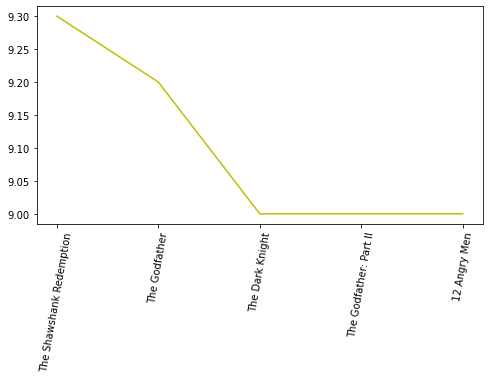

In [ ]:
# les films au top des notes
fig = plt.figure(1, figsize=(8, 4))
plt.plot(top.originalTitle, top.averageRating	, c='y' )
plt.xlabel='top movie'
plt.ylabel='average rating'
plt.title = "The top rated movies"
plt.xticks(rotation=80)
plt.show()

The Shawshank Redemption (Drama)	ET  The Godfather	(Crime,Drama) sont les mieux notés?   

Remarquons que des genres particuliers sont mieux notés. 

Nous allons étudier ces genres en nous basant  sur le 85 ème percentile plutôt que le 95 ème, en assouplissant nos conditions

In [ ]:
# dimensions de la base de données
df.shape

(9552, 10)

In [ ]:
# créons un dataframe avec un index à plusieurs niveaux et supprimons le précedent index
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)

In [ ]:
# dimensions de la base de données
df.shape

(9552, 10)

In [ ]:
# affichons les colonnes
df.columns

Index(['tconst', 'titleType', 'originalTitle', 'startYear', 'runtimeMinutes',
       'genres', 'averageRating', 'numVotes', 'primaryName', 'wr'],
      dtype='object')

#Fonction Build-chart

In [ ]:
# notre fonction pour notre analyse
def build_chart(genre, percentile=0.85):
  

    df = gen_df[gen_df ['genre'].str.contains(genre, regex=False)                                    ]
    numVotes= df[df['numVotes'].notnull()]['numVotes'].astype('int')
    averageRating = df[df['averageRating'].notnull()]['averageRating'].astype('int')

    C =averageRating.mean()
    m = numVotes.quantile(percentile)

  
    chart = df[(df['numVotes'] >= m) & (df['numVotes'].notnull()) & (df['averageRating'].notnull())][['tconst', 'titleType', 'originalTitle', 'startYear', 'runtimeMinutes',
       'averageRating', 'numVotes', 'primaryName']]
    chart['numVotes'] = chart['numVotes'].astype('int')
    chart['averageRating'] = chart['averageRating'].astype('int')
    
    chart['wr'] = chart.apply(lambda x: (x['numVotes']/(x['numVotes']+m) * x['averageRating']) + (m/(m+x['numVotes']) * C), axis=1)
    chart = chart.sort_values('wr', ascending=False).head(250)
    
    return chart

In [ ]:
# the differents "genres" of the dataset
df.genres.value_counts()

Comedy,Drama,Romance     463
Drama                    392
Comedy,Drama             378
Drama,Romance            326
Comedy                   291
                        ... 
Action,Sport,Thriller      1
Music,Thriller             1
Action,Comedy,Mystery      1
Comedy,Family,Musical      1
Action,Family,Sport        1
Name: genres, Length: 454, dtype: int64

In [ ]:
# testons notre fonction sur le genre "Comedy"
build_chart ("Comedy" ).head(5)

,tconst,titleType,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,primaryName,wr
33,tt0088763,movie,Back to the Future,1985,116,8,1074658,"Michael J. Fox,Crispin Glover,Christopher Lloy...",7.810056
35,tt2015381,movie,Guardians of the Galaxy,2014,121,8,1058159,"John C. Reilly,Benicio Del Toro,Gregg Henry,Mi...",7.807383
48,tt0266543,movie,Finding Nemo,2003,100,8,960260,"Ellen DeGeneres,Andrew Stanton,Pierre Auger,Mi...",7.789830
50,tt0120382,movie,The Truman Show,1998,103,8,955661,"Ed Harris,Noah Emmerich,Natascha McElhone,Noah...",7.788926
52,tt1049413,movie,Up,2009,96,8,948188,"Edward Asner,James Burgess,Scott Clark,Lisa El...",7.787441


La colonne "genres" contient plusieurs valeurs non "explosées". afin de contourner cet obstacle nous avons introduit dans notre fonction "build_chart" une appartenance plutôt qu'une correpondance, via la méthode  
                 *str.contains* ().

In [ ]:
# testons notre fonction avec par exemple "Fantasy,Musical,Romance "
build_chart ("Fantasy,Musical,Romance" ).head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,primaryName,wr
8068,tt0081777,movie,Xanadu,1980,96,5,12273,"Olivia Newton-John,Lynn Latham,Rick Anderson,L...",5.0


#A priori notre fonction est optimisée   😂 

In [ ]:
# a view of the column "genres"
df.genres

0                    Drama
9              Crime,Drama
1       Action,Crime,Drama
29             Crime,Drama
111            Crime,Drama
               ...        
2516     Documentary,Music
4168        Drama,Thriller
4135                Comedy
2588       Biography,Drama
2816          Action,Drama
Name: genres, Length: 9552, dtype: object

In [ ]:
# que contient le genres "Action,Comedy,Drama" ?
df [df.genres =="Action,Comedy,Drama"].head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,wr
8118,tt1128075,movie,Ai no mukidashi,2008,237,"Action,Comedy,Drama",8.1,12168,"Yoriko Dôguchi,Mitsuru Fukikoshi,Keisuke Horib...",7.028677
7650,tt0019421,movie,"Steamboat Bill, Jr.",1928,70,"Action,Comedy,Drama",7.9,13451,"Buster Keaton,Marion Byron,Carl Harbaugh,Tom L...",6.970233
7384,tt0093578,movie,Mr. India,1987,179,"Action,Comedy,Drama",7.8,14253,"Bob Christo,Bijon Das Gupta,Veeru Devgan,Boney...",6.941082
7108,tt0495034,movie,Golmaal: Fun Unlimited,2006,150,"Action,Comedy,Drama",7.4,15247,"Sharman Joshi,Mukesh Tiwari,Rajiv Varma,Neeraj...",6.725308
4573,tt0347473,movie,Main Hoon Na,2004,182,"Action,Comedy,Drama",7.0,32586,"Farah Khan,Nassar Abdulla,Bindu,Sabu Cyril,Vas...",6.693231


In [ ]:
# que contient le genres "Drama" ?
df [df.genres =="Drama"].head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,wr
0,tt0111161,movie,The Shawshank Redemption,1994,142,Drama,9.3,2377444,"Stephen King,Tim Robbins,Clancy Brown,Mark Rol...",9.285914
3,tt0137523,movie,Fight Club,1999,139,Drama,8.8,1881308,"Helena Bonham Carter,Meat Loaf,Alison Anne Abr...",8.784614
54,tt0073486,movie,One Flew Over the Cuckoo's Nest,1975,133,Drama,8.7,929061,"Jack Nicholson,Brad Dourif,Scatman Crothers,Lo...",8.669962
37,tt0120586,movie,American History X,1998,119,Drama,8.5,1045374,"Fairuza Balk,Beverly D'Angelo,Edward Furlong,J...",8.474994
32,tt0169547,movie,American Beauty,1999,122,Drama,8.3,1080546,"Kevin Spacey,Thora Birch,Scott Bakula,Annette ...",8.277464


In [ ]:
# "Action,Adventure,Sci-Fi" 
df [df.genres =="Action,Adventure,Sci-Fi"].head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,wr
2,tt1375666,movie,Inception,2010,148,"Action,Adventure,Sci-Fi",8.8,2099808,"Leonardo DiCaprio,Tom Berenger,Pete Postlethwa...",8.786208
67,tt4154756,movie,Avengers: Infinity War,2018,149,"Action,Adventure,Sci-Fi",8.4,865375,"Josh Brolin,Chris Petts,Russell Bobbitt,Susan ...",8.370882
128,tt0090605,movie,Aliens,1986,137,"Action,Adventure,Sci-Fi",8.3,659851,"Bill Paxton,Michael Biehn,Lance Henriksen,Jene...",8.263291
60,tt1392190,movie,Mad Max: Fury Road,2015,120,"Action,Adventure,Sci-Fi",8.1,895959,"Charlize Theron,Christopher DeFaria,Keith Adam...",8.074870
62,tt0107290,movie,Jurassic Park,1993,127,"Action,Adventure,Sci-Fi",8.1,879448,"Jeff Goldblum,Richard Attenborough,Laura Dern,...",8.074403


In [ ]:
# "Biography,Crime,Drama"
df [df.genres =="Biography,Crime,Drama"].head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,wr
39,tt0099685,movie,Goodfellas,1990,146,"Biography,Crime,Drama",8.7,1036632,"Martin Scorsese,Ray Liotta,Joe Pesci,Paul Sorv...",8.673052
23,tt0993846,movie,The Wolf of Wall Street,2013,180,"Biography,Crime,Drama",8.2,1213606,"Leonardo DiCaprio,Rob Reiner,Christine Ebersol...",8.180658
71,tt0264464,movie,Catch Me If You Can,2002,141,"Biography,Crime,Drama",8.1,849382,"Christopher Walken,Nathalie Baye,Kam Heskin,Fr...",8.073507
304,tt1895587,movie,Spotlight,2015,129,"Biography,Crime,Drama",8.1,427806,"Michael Keaton,Liev Schreiber,Stanley Tucci,To...",8.047940
1226,tt0107207,movie,In the Name of the Father,1993,133,"Biography,Crime,Drama",8.1,159936,"Alan Amsby,Don Baker,Alan Barry,Jimmie Bergin,...",7.965423


In [ ]:
# prenons un film assigné à trois genres et testons notre FONCTION
df[df.originalTitle == "Inception"]

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,wr
2,tt1375666,movie,Inception,2010,148,"Action,Adventure,Sci-Fi",8.8,2099808,"Leonardo DiCaprio,Tom Berenger,Pete Postlethwa...",8.786208


In [ ]:
# "Inception" est imputé à trois genres, en incluant uniquement un type de genre, notre fontion accède aux données
build_chart("Adventure").head(2)

,tconst,titleType,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,primaryName,wr
2,tt1375666,movie,Inception,2010,148,8,2099808,"Leonardo DiCaprio,Tom Berenger,Pete Postlethwa...",7.780802
7,tt0120737,movie,The Lord of the Rings: The Fellowship of the Ring,2001,178,8,1683966,"Liv Tyler,Sean Astin,Sean Bean,Ian Holm,Christ...",7.734134


In [ ]:
# notre fonction "build_chart" avec "Comedy"
build_chart("Comedy").head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,primaryName,wr
33,tt0088763,movie,Back to the Future,1985,116,8,1074658,"Michael J. Fox,Crispin Glover,Christopher Lloy...",7.810056
35,tt2015381,movie,Guardians of the Galaxy,2014,121,8,1058159,"John C. Reilly,Benicio Del Toro,Gregg Henry,Mi...",7.807383
48,tt0266543,movie,Finding Nemo,2003,100,8,960260,"Ellen DeGeneres,Andrew Stanton,Pierre Auger,Mi...",7.789830
50,tt0120382,movie,The Truman Show,1998,103,8,955661,"Ed Harris,Noah Emmerich,Natascha McElhone,Noah...",7.788926
52,tt1049413,movie,Up,2009,96,8,948188,"Edward Asner,James Burgess,Scott Clark,Lisa El...",7.787441


Le film "Back to the Future" est un classique du genre. Michael J. Fox est devenu un star planétaire

# Recommandation

la base de données "movies_metadata" est une base  spécifique aux films produits. Elle contient les métadonnées.

In [ ]:
# importons une nouvelle base de données "movies-metadata". Nous allons y intégrer des métadonnées (surtout les overview et tagline) = aperçu et slogan
movies_metadata=pd.read_csv('/content/drive/MyDrive/movies_metadata.csv')

In [ ]:
# affichons les colonnes et ainsi avoir un aperçu
movies_metadata.columns
movies_metadata.shape

(45466, 24)

In [ ]:
# rename the column "original_title"
movies_metadata = movies_metadata.rename({'original_title': 'originalTitle'}, axis=1)
movies_metadata = movies_metadata.rename({'production_countries': 'country'}, axis=1)
movies_metadata = movies_metadata.rename({'spoken_languages': 'language'}, axis=1)
movies_metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,originalTitle,overview,popularity,poster_path,production_companies,country,release_date,revenue,runtime,language,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [ ]:
# affichons les colonnes et ainsi vérifier le renommage
df.columns

Index(['tconst', 'titleType', 'originalTitle', 'startYear', 'runtimeMinutes',
       'genres', 'averageRating', 'numVotes', 'primaryName', 'wr'],
      dtype='object')

In [ ]:
# merge "df" and "movies-metadata"
df = pd.merge(df, movies_metadata,   on='originalTitle')

In [ ]:
# les dimensions de notre dataframe
df.shape

(9180, 33)

In [ ]:
df.columns

Index(['tconst', 'titleType', 'originalTitle', 'startYear', 'runtimeMinutes',
       'genres_x', 'averageRating', 'numVotes', 'primaryName', 'wr', 'adult',
       'belongs_to_collection', 'budget', 'genres_y', 'homepage', 'id',
       'imdb_id', 'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'country', 'release_date', 'revenue', 'runtime',
       'language', 'status', 'tagline', 'title', 'video', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
# supprimons les colonnes non utiles à notre analyse
df= df.drop(columns =['adult', 'belongs_to_collection', 'budget', 'homepage', 'poster_path',
       'production_companies',  'release_date',  'status',  'video', 'vote_average',
       'vote_count'        ], axis=1) 

In [ ]:
# supprimons deux dernières colonnes
df = df.drop (columns= ['genres_y','runtime',    ], axis=1   ) 

In [ ]:
df.columns

Index(['tconst', 'titleType', 'originalTitle', 'startYear', 'runtimeMinutes',
       'genres_x', 'averageRating', 'numVotes', 'primaryName', 'wr', 'id',
       'imdb_id', 'original_language', 'overview', 'popularity', 'country',
       'revenue', 'language', 'tagline', 'title'],
      dtype='object')

In [ ]:
#renomons la colonne
df = df.rename({'genres_x': 'genres'}, axis=1)

In [ ]:
# nos colonnes
df.columns

Index(['tconst', 'titleType', 'originalTitle', 'startYear', 'runtimeMinutes',
       'genres', 'averageRating', 'numVotes', 'primaryName', 'wr', 'id',
       'imdb_id', 'original_language', 'overview', 'popularity', 'country',
       'revenue', 'language', 'tagline', 'title'],
      dtype='object')

In [ ]:
# assurons-nous de l'intégrité des colonnes "tagline" et overview
# les recommandations seront basées sur des descriptions et des slogans (variables qualitatives)
df['tagline'] = df['tagline'].fillna('')
df['description'] = df['overview'] + df['tagline']
df['description'] = df['description'].fillna('')

Appuyons-nous sur des ressources provenant du WEB

TF - IDF( pour la fouille de textes) :  
https://fr.wikipedia.org/wiki/TF-IDF  


Matrice de fonctionnalités :  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
# transformons nos documents bruts en matrice de fonctionnalités TF_IDF
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['description'])

In [ ]:
# dimension de notre matice
tfidf_matrix.shape

(9180, 242658)

linear_kernel ( le noyau linéaire )  :  

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html


In [ ]:
# nos calculs
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# nos calculs
cosine_sim[0]

array([1.        , 0.00151128, 0.        , ..., 0.        , 0.00687894,
       0.00116161])

Ayant une matrice de similitude cosinus par paire pour tous les films. Nous allons écrire une fonction qui renvoie les 30 films les plus similaires en fonction du score de similarité cosinus.

In [ ]:
# revoyons nos indexes
df = df.reset_index() 
titles = df['title']
indices = pd.Series(df.index, index=df['title'])

#Fonction recommandation

In [ ]:
# établissons une fonction de recommandation en renvoyant la localisation des similarités
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

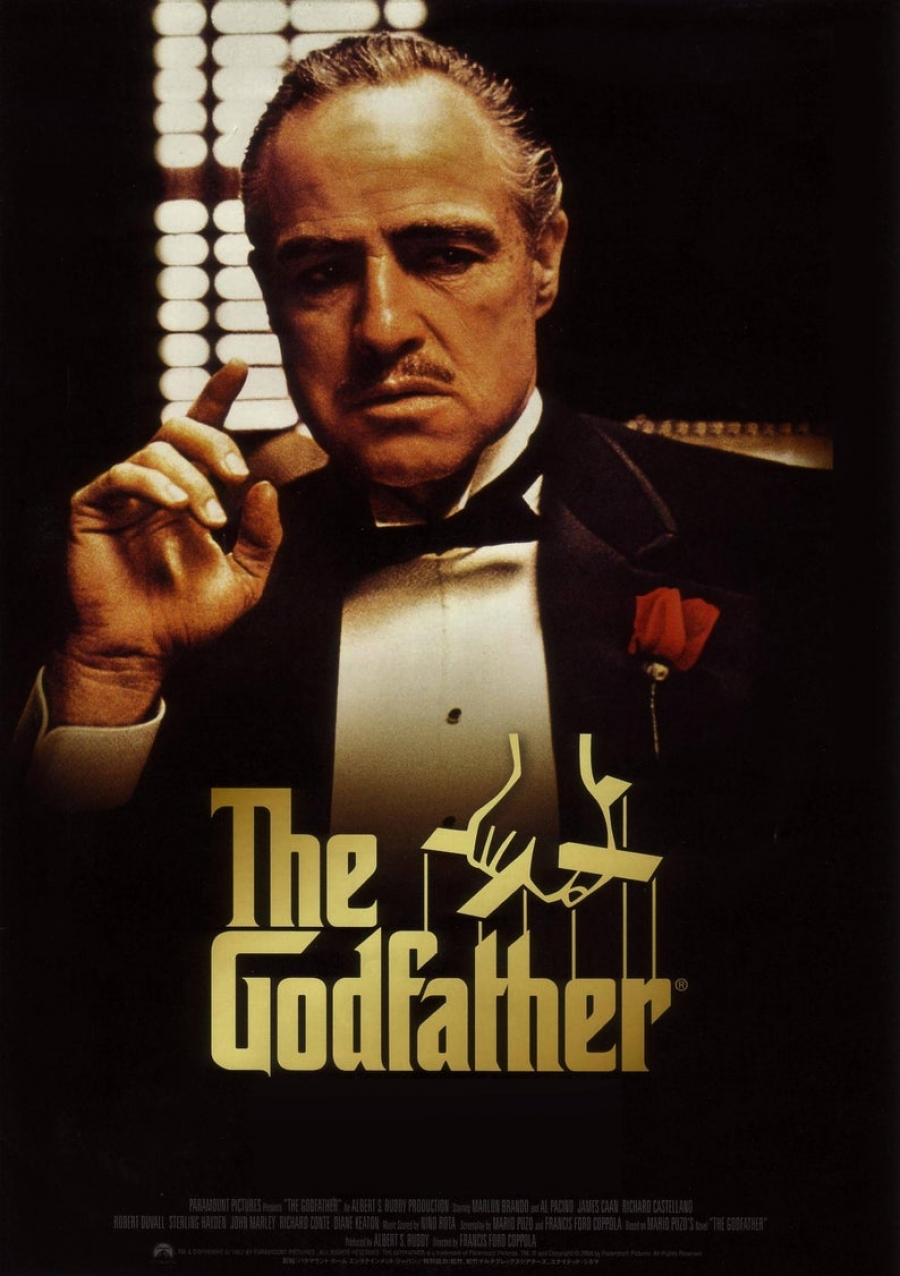

In [ ]:
# une recommandation de 20 films
get_recommendations('The Godfather').head(20)

4        The Godfather: Part II
5752                 The Family
5893                 Blood Ties
6308                       Made
5968         Johnny Dangerously
7781                  Miss Bala
5576              Live by Night
1923             American Movie
732                        Fury
734                        Fury
2656                    Maqbool
4164              Loose Cannons
747     The Godfather: Part III
7876          Playing for Keeps
3258                    8 Women
4589              Summer of Sam
4378              Run All Night
697            The Color Purple
9153          Jaws: The Revenge
7659                    Thinner
Name: title, dtype: object

In [ ]:
# une recommandation de 15 films
get_recommendations('The Shawshank Redemption').head(15)

776             Les Misérables
783             Les Misérables
646                     Talvar
4802            Goodbye Bafana
1431                 Innocence
2867              The Woodsman
3921               Brute Force
3648               Escape Plan
5332                       Red
2389               The Getaway
2391               The Getaway
6072            Coogan's Bluff
2720                Demolition
1994    The 40 Year Old Virgin
502                  A Prophet
Name: title, dtype: object

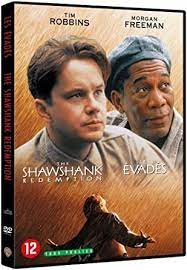

In [ ]:
# une recommandation de 5 films
get_recommendations('American History X').head(5)

8789          Obsessed
4125         Zoolander
3304            Detour
7243      Blind Dating
553     Ocean's Eleven
Name: title, dtype: object

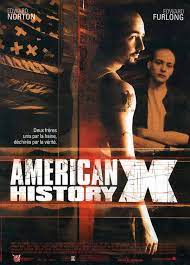

In [ ]:
# une recommandation de 40 films  ---- Pourquoi 40 ?     Pour le fun !
get_recommendations('Limitless').head(40)

4477                                Run
2371             A Street Cat Named Bob
5418                 Kill Your Darlings
1529                              Crumb
7157                                Una
2452                 Inside I'm Dancing
2570                 Night and the City
78                             Scarface
7177                          Senseless
7671             What's Up, Tiger Lily?
5630           Riding in Cars with Boys
5685                             Hitman
2867                       The Woodsman
1129                             Looper
6478                   I Am Number Four
3049    Alice Doesn't Live Here Anymore
5637                 Ghost in the Shell
6016            The Man with Two Brains
2482                    P.S. I Love You
6880                        The Meddler
7562                            Phantom
6741                            Soldier
2585                       The Stranger
9116               Fifty Shades of Grey
2149                       Side Effects


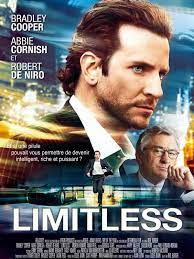

In [ ]:
get_recommendations('Trois ').head(5)

#😊  **Aimons les nuages de mots !   Ils souligent des informations.**


In [ ]:
# dressons un nuage de mots portant sur les titres (" j'adore cela ")
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# vérifions que la colonne est bien en string
df['originalTitle'] = df['originalTitle'].astype('str')

In [ ]:
# transformos en corpus
title_corpus = ' '.join(df['originalTitle'])

In [ ]:
# affichons le corpus" --- nous enlevons le maximu de pponctuation et les "stopwords" (en anglais)
title_corpus

"The Shawshank Redemption The Godfather The Dark Knight The Dark Knight The Godfather: Part II 12 Angry Men 12 Angry Men Pulp Fiction The Lord of the Rings: The Return of the King Schindler's List Inception Fight Club Forrest Gump The Lord of the Rings: The Fellowship of the Ring Il buono, il brutto, il cattivo The Matrix The Lord of the Rings: The Two Towers One Flew Over the Cuckoo's Nest Interstellar Se7en The Silence of the Lambs Saving Private Ryan Star Wars The Green Mile Cidade de Deus La vita è bella It's a Wonderful Life Gladiator The Prestige The Departed Back to the Future Léon American History X Terminator 2: Judgment Day The Usual Suspects The Lion King The Lion King Intouchables The Pianist Whiplash Whiplash Whiplash Psycho Psycho Psycho Psycho Casablanca C'era una volta il West Nuovo Cinema Paradiso Modern Times The Dark Knight Rises Django Unchained Memento WALL·E Joker The Shining Raiders of the Lost Ark Alien Apocalypse Now City Lights Dr. Strangelove or: How I Learne

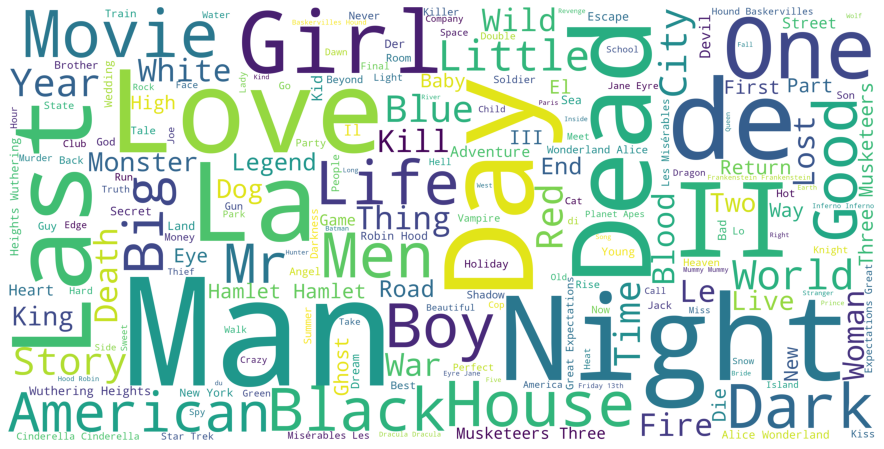

In [ ]:
# dessinons notre nuage de mots basé sur les titres 
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Les recommandations semblent pertinentes.  

Elles sont prodiguées en fontion des similarités des contenus.  

Nous allons les affiner en nous appuyant sur L'algorithme des K plus proches voisins ou K-nearest neighbors (kNN). C'est un algorithme de Machine Learning qui appartient à la classe des algorithmes d'apprentissage supervisé. Il est orienté vers la résolution de problèmes de classification et de régression.

# PASSONS AU KNN

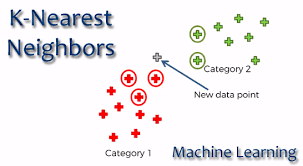